<a href="https://colab.research.google.com/github/JSrabonee/COVID_paper_diagrams/blob/main/Copy_of_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up kaggle** *: to download data from kaggle*

In [ ]:
# ! pip install kaggle

In [ ]:
# ! mkdir /content/drive/MyDrive/COVID_Paper/Data/.kaggle

In [ ]:
# ! cp kaggle.json /content/drive/MyDrive/COVID_Paper/Data/.kaggle/

In [ ]:
# ! chmod 600 /content/drive/MyDrive/COVID_Paper/Data/.kaggle/kaggle.json

# Downloading Data

In [ ]:
# ! kaggle datasets download spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask

# Unzipping Data

In [ ]:
# ! unzip /content/drive/MyDrive/COVID_Paper/Data/face-mask-detectormask-not-mask-incorrect-mask.zip -d /content/drive/MyDrive/COVID_Paper/Data/Kaggle_improper_mask/

In [ ]:
full_data_dir = '/content/drive/MyDrive/COVID_Paper/Data/kaggleDataIncorrectMask/'
model_dir = '/content/drive/MyDrive/COVID_Paper/Output/saved_models/'

# Impoting necessary library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorboard
tensorboard.__version__

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.6.0


In [ ]:
incorrect_mask_data_dir = '/content/drive/MyDrive/COVID_Paper/Data/kaggleDataIncorrectMask/incorrect_mask/'
with_mask_data_dir = '/content/drive/MyDrive/COVID_Paper/Data/kaggleDataIncorrectMask/with_mask/'
without_mask_data_dir = '/content/drive/MyDrive/COVID_Paper/Data/kaggleDataIncorrectMask/without_mask/'

incorrect_mask_image_count = len(os.listdir(incorrect_mask_data_dir))
with_mask_image_count = len(os.listdir(with_mask_data_dir))
without_mask_image_count = len(os.listdir(without_mask_data_dir))

print('Number of incorrectly worn mask samples: ',incorrect_mask_image_count)
print('Number of correctly worn mask samples: ',with_mask_image_count)
print('Number of not wearing a mask samples: ',without_mask_image_count)

fig_dir = '/content/drive/MyDrive/COVID_Paper/Output/'
output_dir = '/content/drive/MyDrive/COVID_Paper/Output/'

Number of incorrectly worn mask samples:  680
Number of correctly worn mask samples:  690
Number of not wearing a mask samples:  686


# Loading Data using Keras Utility: train-validation split

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(full_data_dir,
    labels="inferred",
    label_mode="int", # 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    class_names=['incorrect_mask','with_mask', 'without_mask'],
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed = 42,
    validation_split=0.2,
    subset= "training",
    interpolation="bilinear",   # the interpolation method used when resizing images.
    follow_links=False,
    crop_to_aspect_ratio=False,  # If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio.
)

Found 2056 files belonging to 3 classes.
Using 1645 files for training.


In [ ]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(full_data_dir,
    labels="inferred",
    label_mode="int", # 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    class_names=['incorrect_mask','with_mask', 'without_mask'],
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed = 42,
    validation_split=0.2,
    subset= "validation",
    interpolation="bilinear",   # the interpolation method used when resizing images.
    follow_links=False,
    crop_to_aspect_ratio=False,  # If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio.
)

Found 2056 files belonging to 3 classes.
Using 411 files for validation.


**Creating Test Set**

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches // 5)
validation_data = validation_data.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 11
Number of test batches: 2


**Class names**

In [ ]:
class_names = train_data.class_names
print(class_names)

['incorrect_mask', 'with_mask', 'without_mask']


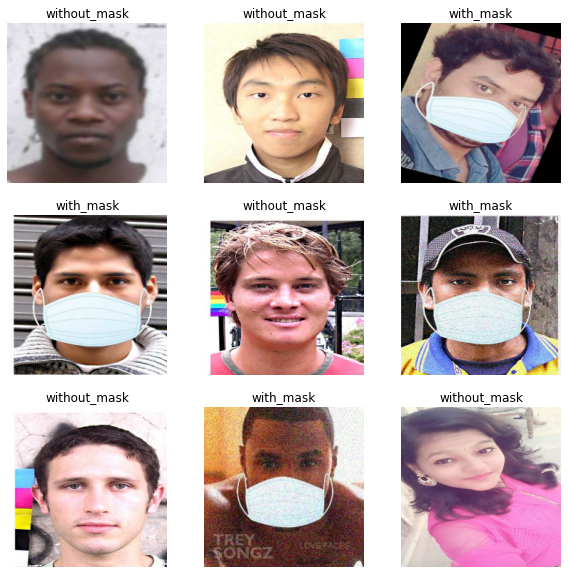

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Model with dropout layer

In [ ]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'],
              )

In [ ]:
!pip install visualkeras

In [ ]:
# Define the Keras TensorBoard callback.
logdir="/content/drive/MyDrive/COVID_Paper/Code/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
epochs = 30
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs,
  callbacks=[tensorboard_callback],
)
model.save(model_dir + 'CNN_model')

Epoch 1/30
52/52 [==============================] - 15s 218ms/step - loss: 0.9878 - accuracy: 0.6000 - val_loss: 0.4169 - val_accuracy: 0.8213
Epoch 2/30
52/52 [==============================] - 11s 190ms/step - loss: 0.3752 - accuracy: 0.8584 - val_loss: 0.2824 - val_accuracy: 0.9107
Epoch 3/30
52/52 [==============================] - 11s 190ms/step - loss: 0.2477 - accuracy: 0.9106 - val_loss: 0.1942 - val_accuracy: 0.9395
Epoch 4/30
52/52 [==============================] - 11s 192ms/step - loss: 0.1851 - accuracy: 0.9325 - val_loss: 0.1602 - val_accuracy: 0.9597
Epoch 5/30
52/52 [==============================] - 11s 187ms/step - loss: 0.1095 - accuracy: 0.9653 - val_loss: 0.1070 - val_accuracy: 0.9683
Epoch 6/30
52/52 [==============================] - 11s 186ms/step - loss: 0.0716 - accuracy: 0.9763 - val_loss: 0.1228 - val_accuracy: 0.9712
Epoch 7/30
52/52 [==============================] - 11s 190ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.1020 - val_accuracy: 0.9683

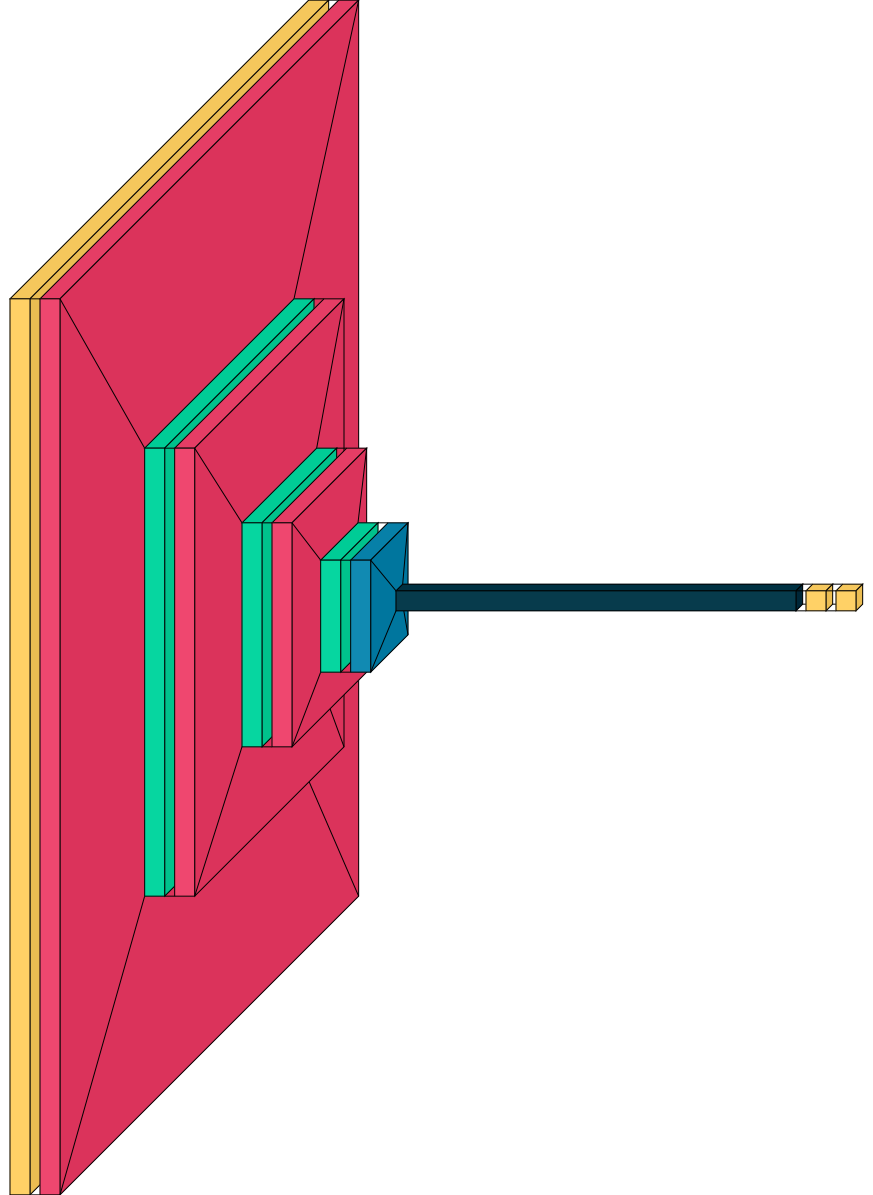

In [ ]:
import visualkeras
from PIL import ImageFont


path = '/content/drive/MyDrive/COVID_Paper/Code/'


font = ImageFont.truetype(path + "arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True,to_file= fig_dir + 'output.png', font = font )  # font is optional!
visualkeras.layered_view(model, legend= True, to_file= fig_dir + 'output.png',font = font).show() # write and show

visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [ ]:
model.save(output_dir + "CNN.model", save_format="h5")

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

pred = []
for i in range(0, len(predictions)):
  pred.append(np.argmax(predictions[i]))
pred = np.asarray(pred)

print('Predictions:\n', pred)
print('Labels:\n', label_batch)

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(label_batch, pred)
print(confusion_matrix)
print('\n')

TP_incorrect_mask = confusion_matrix[0][0]
TP_with_mask      = confusion_matrix[1][1]
TP_without_mask   = confusion_matrix[2][2]

FP_incorrect_mask = confusion_matrix[1][0] + confusion_matrix[2][0]
FP_with_mask      = confusion_matrix[0][1] + confusion_matrix[2][1]
FP_without_mask   = confusion_matrix[0][2] + confusion_matrix[1][2]

TN_incorrect_mask = confusion_matrix[1][1] + confusion_matrix[1][2] + confusion_matrix[2][1] + confusion_matrix[2][2]
TN_with_mask      = confusion_matrix[0][0] + confusion_matrix[0][2] + confusion_matrix[2][0] + confusion_matrix[2][2]
TN_without_mask   = confusion_matrix[0][0]+ confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1]

FN_incorrect_mask = confusion_matrix[0][1] + confusion_matrix[0][2]
FN_with_mask      = confusion_matrix[1][0] + confusion_matrix[1][2]
FN_without_mask   = confusion_matrix[2][0] + confusion_matrix[2][1] 

accuracy = ((confusion_matrix[0][0] + confusion_matrix[1][1] + confusion_matrix[2][2]) / len(label_batch)) * 100

precision_incorrect_mask = TP_incorrect_mask / (TP_incorrect_mask + FP_incorrect_mask)
precision_with_mask      = TP_with_mask / (TP_with_mask + FP_with_mask)
precision_without_mask   = TP_without_mask / (TP_without_mask + FP_without_mask)

recall_incorrect_mask = TP_incorrect_mask / (TP_incorrect_mask + FN_incorrect_mask)
recall_with_mask      = TP_with_mask / (TP_with_mask + FN_with_mask)
recall_without_mask   = TP_without_mask / (TP_without_mask + FN_without_mask)

f1_score_incorrect_mask = (2 * recall_incorrect_mask * precision_incorrect_mask) / (recall_incorrect_mask + precision_incorrect_mask)
f1_score_with_mask = (2 * recall_with_mask      * precision_with_mask)      / (recall_with_mask      + precision_with_mask)
f1_score_without_mask = (2 * recall_without_mask   * precision_without_mask)   / (recall_without_mask   + precision_without_mask)

print('Accuracy: ',accuracy)
print('\n')
print('precision_incorrect_mask', precision_incorrect_mask)
print('precision_with_mask', precision_with_mask)
print('precision_without_mask', precision_without_mask)
print('\n')
print('recall_incorrect_mask', recall_incorrect_mask)
print('recall_with_mask', recall_with_mask)
print('recall_without_mask', recall_without_mask)
print('\n')
print('f1_score_incorrect_mask', f1_score_incorrect_mask)
print('f1_score_with_mask', f1_score_with_mask)
print('f1_score_without_mask', f1_score_without_mask)

Predictions:
 [1 2 2 2 2 2 2 2 2 1 1 1 0 1 1 0 2 1 2 0 1 1 0 2 1 1 1 2 1 1 2 1]
Labels:
 [1 2 2 2 2 2 2 2 2 1 1 1 0 1 1 0 2 1 2 0 1 1 0 2 1 2 1 2 1 1 2 1]
[[ 4  0  0]
 [ 0 14  0]
 [ 0  1 13]]


Accuracy:  96.875


precision_incorrect_mask 1.0
precision_with_mask 0.9333333333333333
precision_without_mask 1.0


recall_incorrect_mask 1.0
recall_with_mask 1.0
recall_without_mask 0.9285714285714286


f1_score_incorrect_mask 1.0
f1_score_with_mask 0.9655172413793104
f1_score_without_mask 0.962962962962963


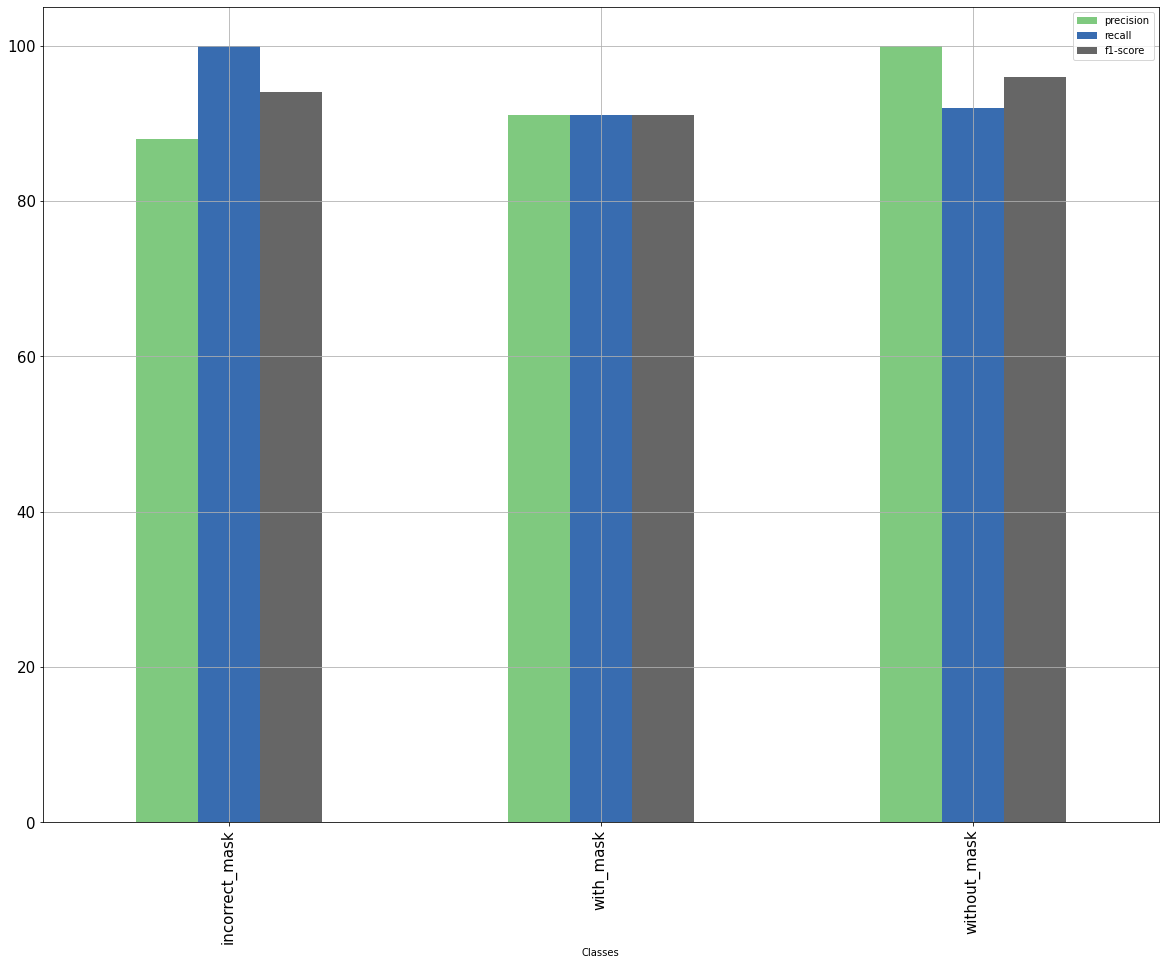

In [ ]:
import pandas as pd
csv_dir = '/content/drive/MyDrive/COVID_Paper/Output/CNN.csv'
output = pd.read_csv(csv_dir, index_col= 0)
colormap = 'Accent'

output[output.columns].plot(figsize=(20,15), colormap = colormap, xlabel = 'Classes', kind='bar',fontsize=15,  grid=True).get_figure().savefig(output_dir + 'CNNmetric.png')

# MobileNetV2

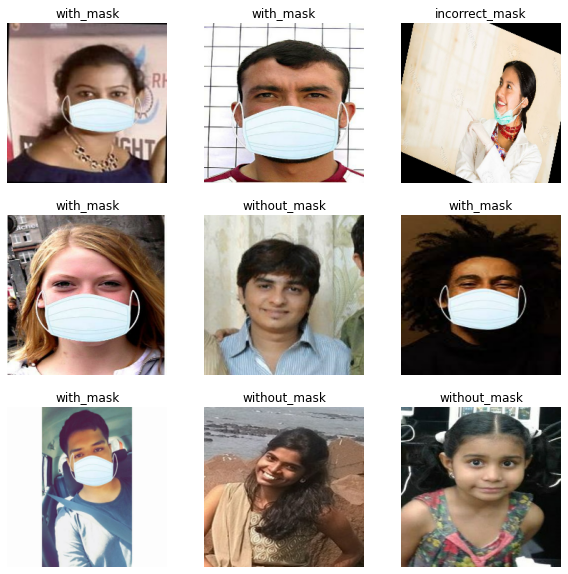

In [ ]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Configure the dataset for performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

**Rescale pixel values**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

**Create the base model from the pre-trained convnets**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation= 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model2 = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model2.evaluate(validation_data)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


11/11 [==============================] - 5s 138ms/step - loss: 1.5871 - accuracy: 0.2421


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.59
initial accuracy: 0.24


In [ ]:
history_mobileNet = model2.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)
model2.save(model_dir + 'MobileNetV2_not fineTuned')

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


52/52 [==============================] - 18s 261ms/step - loss: 1.2948 - accuracy: 0.3781 - val_loss: 0.9070 - val_accuracy: 0.5245
Epoch 2/10
52/52 [==============================] - 12s 203ms/step - loss: 0.8040 - accuracy: 0.6389 - val_loss: 0.5654 - val_accuracy: 0.8473
Epoch 3/10
52/52 [==============================] - 12s 201ms/step - loss: 0.5394 - accuracy: 0.8195 - val_loss: 0.4106 - val_accuracy: 0.9020
Epoch 4/10
52/52 [==============================] - 12s 200ms/step - loss: 0.4036 - accuracy: 0.8954 - val_loss: 0.3093 - val_accuracy: 0.9308
Epoch 5/10
52/52 [==============================] - 12s 199ms/step - loss: 0.3271 - accuracy: 0.9076 - val_loss: 0.2518 - val_accuracy: 0.9424
Epoch 6/10
52/52 [==============================] - 12s 200ms/step - loss: 0.2665 - accuracy: 0.9337 - val_loss: 0.2070 - val_accuracy: 0.9395
Epoch 7/10
52/52 [==============================] - 12s 200ms/step - loss: 0.2320 - accuracy: 0.9416 - val_loss: 0.1856 - val_accuracy: 0.9568
Epoch 8/10

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch = history_mobileNet.epoch[-1],
                         validation_data=validation_data)
model2.save(model_dir + 'MobileNetV2_fineTuned')

Epoch 10/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


52/52 [==============================] - 21s 246ms/step - loss: 0.0754 - accuracy: 0.9812 - val_loss: 0.0432 - val_accuracy: 0.9827
Epoch 11/20
52/52 [==============================] - 15s 273ms/step - loss: 0.0295 - accuracy: 0.9939 - val_loss: 0.0333 - val_accuracy: 0.9856
Epoch 12/20
52/52 [==============================] - 13s 223ms/step - loss: 0.0158 - accuracy: 0.9970 - val_loss: 0.0202 - val_accuracy: 0.9914
Epoch 13/20
52/52 [==============================] - 13s 221ms/step - loss: 0.0073 - accuracy: 0.9994 - val_loss: 0.0246 - val_accuracy: 0.9914
Epoch 14/20
52/52 [==============================] - 13s 222ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.0171 - val_accuracy: 0.9971
Epoch 15/20
52/52 [==============================] - 13s 223ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9942
Epoch 16/20
52/52 [==============================] - 13s 222ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9914
Epoc

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


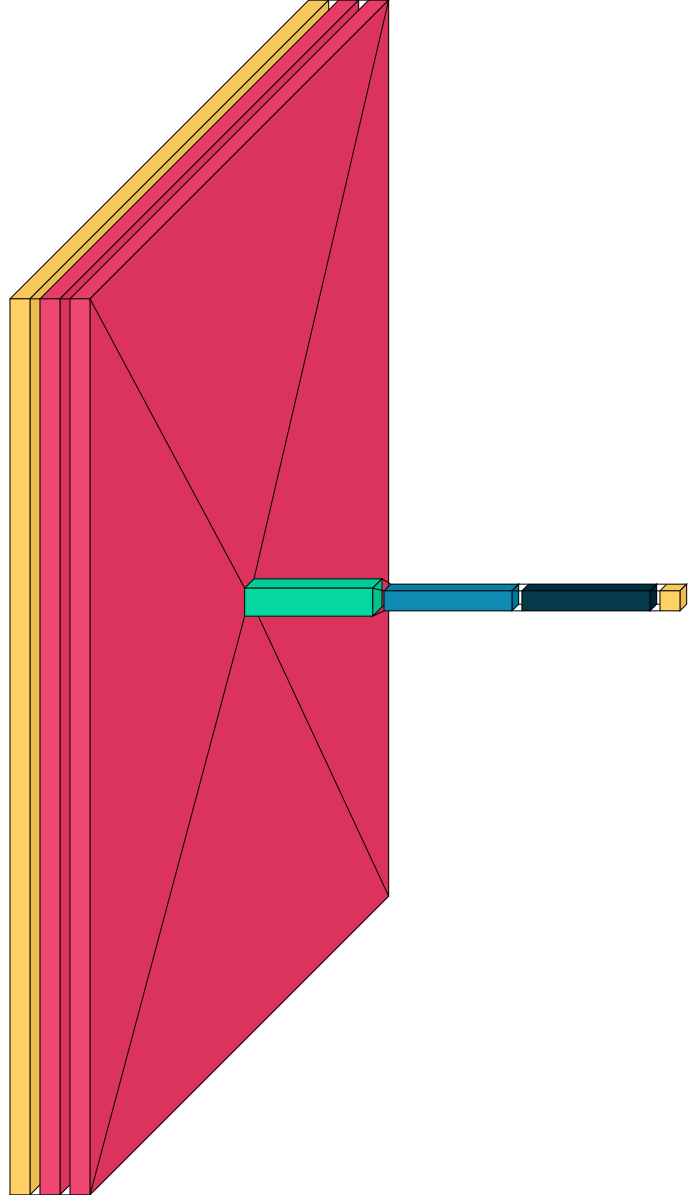

In [ ]:
visualkeras.layered_view(model2).show() # display using your system viewer
visualkeras.layered_view(model2, legend = True, to_file= fig_dir + 'MobileNetV2_output.png', font = font) # write to disk
visualkeras.layered_view(model2, legend= True, to_file= fig_dir + 'MobileNetV2output.png', font = font).show() # write and show

visualkeras.layered_view(model2)

In [ ]:
model.save(output_dir + "MobileNetV2.model", save_format="h5")

In [ ]:
loss, accuracy = model2.evaluate(test_data)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 155ms/step - loss: 0.1089 - accuracy: 0.9688
Test accuracy : 0.96875


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)



plt.style.use('seaborn-whitegrid')

plt.figure(2, figsize=(10, 8), dpi=1200)


plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='CNN training accuracy', color = '#483D8B')
plt.plot(epochs_range, val_acc, label='CNN validation accuracy', marker='s', color = '#CD1076')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 2)
plt.savefig(fig_dir + 'accuracy_curves/CNN_acc.png', dpi=300, format ='png')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='CNN training Loss', color = '#458B00', marker='x' )
plt.plot(epochs_range, val_loss, label='CNN validation Loss', marker='o', color='#FF6103')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 2)
plt.savefig(fig_dir + 'loss_curves/CNN_loss.png', dpi=300, format = 'png')



In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


epochs_range = range(20)



plt.style.use('seaborn-whitegrid')

plt.figure(2, figsize=(10, 8), dpi=1200)


plt.subplot(2, 1, 1)
plt.plot( acc, label='MobileNetV2 training accuracy', color = '#483D8B')
plt.plot( val_acc, label='MobileNetV2 validation accuracy', marker='s', color = '#CD1076')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 2)
plt.savefig(fig_dir + 'accuracy_curves/MobileNetV2_acc.png', dpi=300, format ='png')

plt.subplot(2,1,2)
plt.plot( loss, label='MobileNetV2 training Loss', color = '#458B00', marker='x' )
plt.plot(val_loss, label='MobileNetV2 validation Loss', marker='o', color='#FF6103')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 2)
plt.savefig(fig_dir + 'loss_curves/MobileNetV2_loss.png', dpi=300, format = 'png')



In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model2.predict_on_batch(image_batch)

pred = []
for i in range(0, len(predictions)):
  pred.append(np.argmax(predictions[i]))
pred = np.asarray(pred)

print('Predictions:\n', pred)
print('Labels:\n', label_batch)

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(label_batch, pred)
print(confusion_matrix)
print('\n')

TP_incorrect_mask = confusion_matrix[0][0]
TP_with_mask      = confusion_matrix[1][1]
TP_without_mask   = confusion_matrix[2][2]

FP_incorrect_mask = confusion_matrix[1][0] + confusion_matrix[2][0]
FP_with_mask      = confusion_matrix[0][1] + confusion_matrix[2][1]
FP_without_mask   = confusion_matrix[0][2] + confusion_matrix[1][2]

TN_incorrect_mask = confusion_matrix[1][1] + confusion_matrix[1][2] + confusion_matrix[2][1] + confusion_matrix[2][2]
TN_with_mask      = confusion_matrix[0][0] + confusion_matrix[0][2] + confusion_matrix[2][0] + confusion_matrix[2][2]
TN_without_mask   = confusion_matrix[0][0]+ confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1]

FN_incorrect_mask = confusion_matrix[0][1] + confusion_matrix[0][2]
FN_with_mask      = confusion_matrix[1][0] + confusion_matrix[1][2]
FN_without_mask   = confusion_matrix[2][0] + confusion_matrix[2][1] 

accuracy = ((confusion_matrix[0][0] + confusion_matrix[1][1] + confusion_matrix[2][2]) / len(label_batch)) * 100

precision_incorrect_mask = TP_incorrect_mask / (TP_incorrect_mask + FP_incorrect_mask)
precision_with_mask      = TP_with_mask / (TP_with_mask + FP_with_mask)
precision_without_mask   = TP_without_mask / (TP_without_mask + FP_without_mask)

recall_incorrect_mask = TP_incorrect_mask / (TP_incorrect_mask + FN_incorrect_mask)
recall_with_mask      = TP_with_mask / (TP_with_mask + FN_with_mask)
recall_without_mask   = TP_without_mask / (TP_without_mask + FN_without_mask)

f1_score_incorrect_mask = (2 * recall_incorrect_mask * precision_incorrect_mask) / (recall_incorrect_mask + precision_incorrect_mask)
f1_score_with_mask = (2 * recall_with_mask      * precision_with_mask)      / (recall_with_mask      + precision_with_mask)
f1_score_without_mask = (2 * recall_without_mask   * precision_without_mask)   / (recall_without_mask   + precision_without_mask)

print('Accuracy: ',accuracy)
print('\n')
print('precision_incorrect_mask', precision_incorrect_mask)
print('precision_with_mask', precision_with_mask)
print('precision_without_mask', precision_without_mask)
print('\n')
print('recall_incorrect_mask', recall_incorrect_mask)
print('recall_with_mask', recall_with_mask)
print('recall_without_mask', recall_without_mask)
print('\n')
print('f1_score_incorrect_mask', f1_score_incorrect_mask)
print('f1_score_with_mask', f1_score_with_mask)
print('f1_score_without_mask', f1_score_without_mask)

Predictions:
 [0 0 0 2 1 2 2 1 2 2 1 2 0 0 1 2 0 2 1 2 0 1 0 2 0 2 2 1 2 2 2 2]
Labels:
 [0 0 0 2 1 2 2 1 2 2 1 2 0 0 1 2 0 2 1 2 0 1 0 2 0 2 2 1 2 2 2 2]
[[ 9  0  0]
 [ 0  7  0]
 [ 0  0 16]]


Accuracy:  100.0


precision_incorrect_mask 1.0
precision_with_mask 1.0
precision_without_mask 1.0


recall_incorrect_mask 1.0
recall_with_mask 1.0
recall_without_mask 1.0


f1_score_incorrect_mask 1.0
f1_score_with_mask 1.0
f1_score_without_mask 1.0


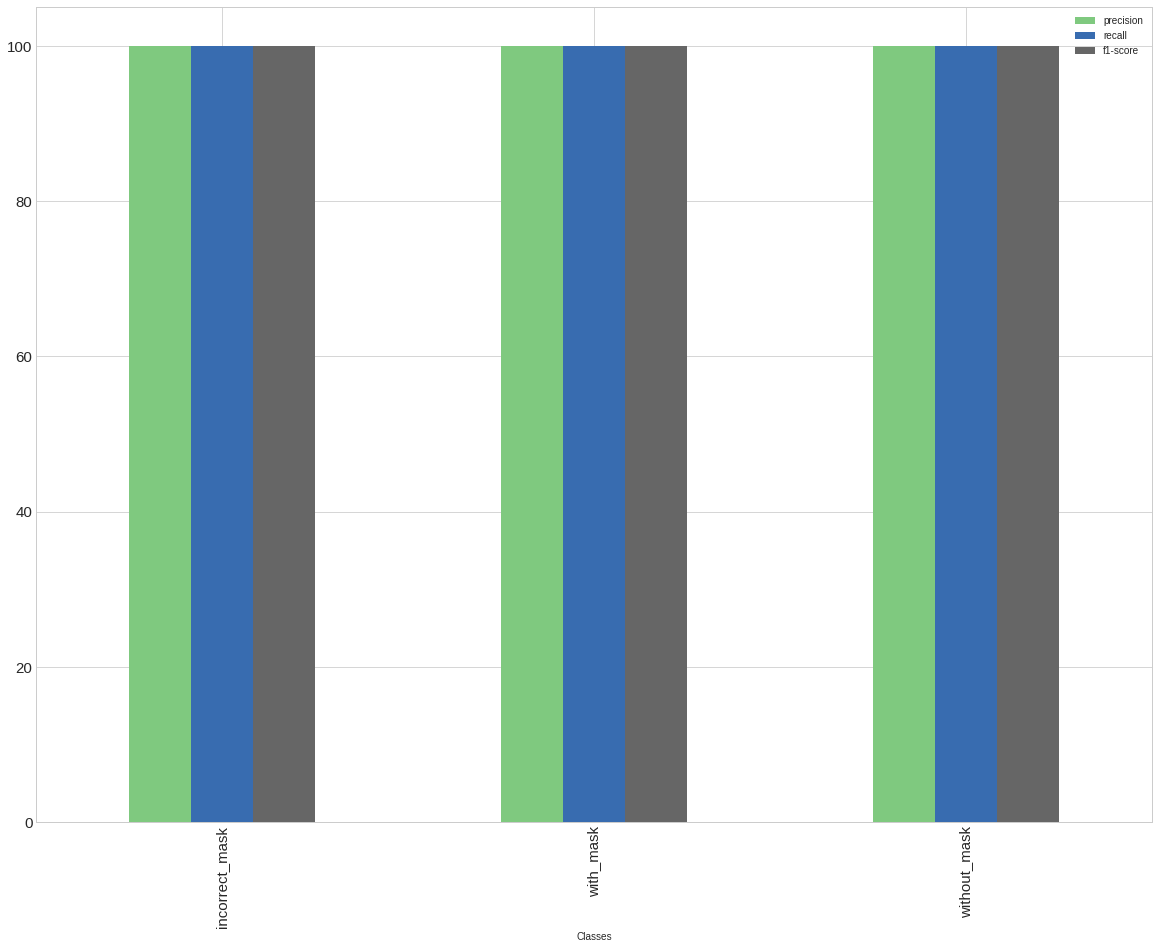

In [ ]:
import pandas as pd

csv_dir = '/content/drive/MyDrive/COVID_Paper/Output/MobileNetV2.csv'
output = pd.read_csv(csv_dir, index_col= 0)
colormap = 'Accent'

output[output.columns].plot(figsize=(20,15), colormap = colormap, xlabel = 'Classes', kind='bar',fontsize=15,  grid=True).get_figure().savefig(output_dir + 'MobileNetV2metric.png')